
# Task 1  - Irises' classification

Your customer is importing flowers (irises) from China. He always buys the same three species: 
- Virginica  
- Versicolor  
- Setosa  

Unfortunately, in the last order all the flowers got mixed up and nobody knows how to distinguish them (what is surprising, even the florist experts were not able to identify them).  Luckily, there are still 150 flowers left from the previous order which are tagged properly.  The client instructed his workers to measure the length and width of their sepals and petals so they could help to classify the newest batch correctly.  

**Goal:** Based on attached data build a model which will classify flower species from the last order. Prepare a report where you describe your way of approaching the problem and the steps you took to solve it. Don’t forget to assess the quality of the model you have prepared.

In [1]:
import os
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [2]:
file = os.getcwd() + r"/Datasets/Graduate - IRISES dataset (2019-06).csv"
print(file)

/home/mab/Code4Life_MAB/Datasets/Graduate - IRISES dataset (2019-06).csv


In [3]:
data = pd.read_csv(file, sep = "|")

# there is one value "2,2", I assume it should be "2.2"
data['Petal.Width'] = data['Petal.Width'].str.replace(',','.')
data['Petal.Width'] = data['Petal.Width'].astype(float)

### Exploratory Data Analysis

In [4]:
print(data.describe(),"\n")
print(data.count())

       Sepal.Length  Sepal.Width  Petal.Length  Petal.Width
count    150.000000   149.000000    150.000000   150.000000
mean       5.779333     3.061745      3.758000     1.199333
std        1.197721     0.433963      1.765298     0.762238
min       -4.800000     2.000000      1.000000     0.100000
25%        5.100000     2.800000      1.600000     0.300000
50%        5.800000     3.000000      4.350000     1.300000
75%        6.400000     3.300000      5.100000     1.800000
max        7.900000     4.400000      6.900000     2.500000 

Sepal.Length    150
Sepal.Width     149
Petal.Length    150
Petal.Width     150
Species         150
dtype: int64


There seem to be some erroneous data in sepal length measurements. It's impossible for a length to be negative (-4.8). There is also one missing value in sepal width. Data is too small to determine if it's missing at random or not. 

There are several options for dealing with missing data:  
- imputation of the missing values
- ommission (even of entire variables if there is enough missing values)
- using methods that won't be affected by missing values

I would ask the provider of the data if the measurements were accurate (maybe the "-" was put there by accident and it was 4.8 originally) and what does the "NA" mean (maybe they meant 0?)

The data is sparse so I am not going to drop anything. Instead I will **replace it average value** for that variable given species. 

In [5]:
# There is only one missing value and it's for spieces "versicolor"
data['Sepal.Width'].fillna((data['Sepal.Width'][data['Species'] == 'versicolor'].mean()), inplace=True)

data.describe()  # worked :)

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
count,150.000000,150.000000,150.000000,150.000000
mean,5.779333,3.059850,3.758000,1.199333
std,1.197721,0.433126,1.765298,0.762238
min,-4.800000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [6]:
setosa_mean_sl = data['Sepal.Length'][data['Sepal.Length'] > 0].mean()
data['Sepal.Length'] = data['Sepal.Length'].apply(lambda x: setosa_mean_sl if x < 0 else x)

data.describe() # worked as well :)

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
count,150.000000,150.000000,150.000000,150.000000
mean,5.850336,3.059850,3.758000,1.199333
std,0.823613,0.433126,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


### Pairplot

We can see here what the categories look like visually

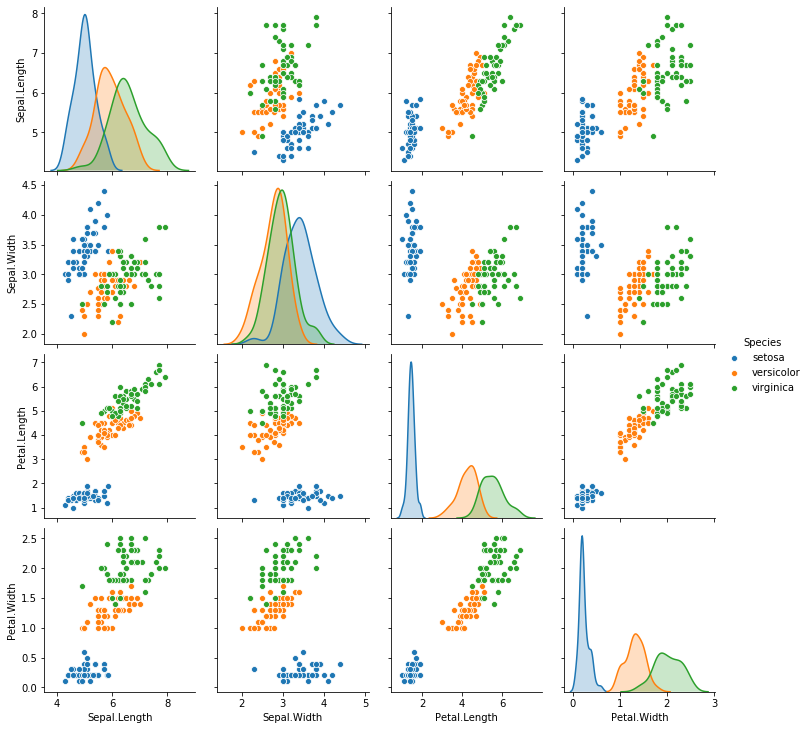

In [7]:
import seaborn as sns
sns.pairplot(data, hue = 'Species')

## Prediction

Since it's a classification problem with labelled data it's a good idea to use one of the supervised algorithms. I decided to go for k-nearest neighbors classifier

In [8]:
import math
import operator
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.preprocessing import scale

import warnings
warnings.filterwarnings("ignore")

In [9]:
x = data[['Sepal.Length', 'Sepal.Width', 'Petal.Length', 'Petal.Width']]
xs = scale(x)

y = data[['Species']]

x_train, x_test, y_train, y_test = train_test_split(xs, y, test_size = 0.2, random_state = 13)

print (x_train.shape)
print (x_test.shape)

(120, 4)
(30, 4)


I am using crossvalidation to test model accuracy because we don't have many samples and that way model will use each observation to learn

In [10]:
cv_scores = []
neighbors = list(np.arange(2,20))

for n in neighbors:
    knn = KNeighborsClassifier(n_neighbors = n, algorithm = 'brute')    
    cross_val = cross_val_score(knn, x_train, y_train, cv = 5, scoring = 'accuracy')
    cv_scores.append(cross_val.mean())
    
optimal_n = neighbors[cv_scores.index(max(cv_scores)) ]

knn_optimal = KNeighborsClassifier(n_neighbors = optimal_n, algorithm = 'brute')
knn_optimal.fit(x_train,y_train)
pred = knn_optimal.predict(x_test)
acc_score = accuracy_score(y_test,pred) * 100

print("The accuracy for optimal k = {0} using brute is {1}".format(optimal_n, acc_score))

The accuracy for optimal k = 7 using brute is 96.66666666666667


We can easily get to a 100% accuracy on that dataset but achieving a little less accurate model is usually better. When the next order of flowers arrive we want our model to perform well on data it hasn't seen before. New flowers will be classified better if the model is not overfitted on the training data